## Analysis of the Mean Square Displacement (MSD) through different time lags

How to run:

If this is the first time running the code OR the MSD calculation functions are being modified, run through all the code blocks in order until the /modified_data folder contains a .pkl file containing a data set that can be reloaded locally.

If strictly manipulating the MSD data for plots and analysis, run the first cell (packages) and the second cell (image folder). Go down to "Data Saving" header and run the "RELOAD MSD DATA:" (cell 5) to load the .pkl dataset from the /modified_data folder. Run the code under "Calculate Mean MSD of all curves" header, along with the "Unit Conversion" header. Data is then ready for plotting. 


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np 
import glob
import os 
import time
import pandas as pd
import pickle
from scipy.stats import linregress
from scipy.interpolate import interp1d

In [ ]:
output_folder = "../msd_images" 
os.makedirs(output_folder, exist_ok=True) 

### Functions
compute_msd_over_time computes the msd of a single bee according to time lags

fill_missing_time_frames fills a bee's data with NaNs to fill empty missing time frames in the dataset of a given bee

In [ ]:
def compute_msd_over_time(traj):
    """
    Compute MSD as a function of time lag Δt for a given trajectory.
    MSD(Δt) = ⟨ (x(t+Δt) - x(t))^2 + (y(t+Δt) - y(t))^2 ⟩
    """
    num_frames = len(traj)
    msd_values = []

    for dt in range(1, num_frames):  # Loop over time lags Δt
        x_t, x_t_dt = traj[:-dt, 1], traj[dt:, 1]  # Extract x at t and t+dt
        y_t, y_t_dt = traj[:-dt, 2], traj[dt:, 2]  # Extract y at t and t+dt

        # Filter out NaNs before subtraction
        valid_mask = ~np.isnan(x_t) & ~np.isnan(x_t_dt) & ~np.isnan(y_t) & ~np.isnan(y_t_dt)
        if np.sum(valid_mask) == 0:  # If all values are NaN, avoid computing MSD
            msd_values.append(np.nan)
            continue

        x_disp = x_t_dt[valid_mask] - x_t[valid_mask]
        y_disp = y_t_dt[valid_mask] - y_t[valid_mask]

        squared_displacements = x_disp**2 + y_disp**2
        msd_values.append(np.mean(squared_displacements))

    return np.array(msd_values)

In [ ]:
'''
extract time column,x,y and then create a time range with the proper amount, 
then make empty arrays,
populate them with known values
return the 2d numpy array
'''

def fill_missing_time_frames(traj, time_min=0, time_max=2998):
    """
    Ensures a trajectory has a complete time series by inserting NaNs at missing time points.
    """
    time = traj[:, 0].astype(int)  # Extract time column (assuming it's in the first column)
    x, y = traj[:, 1], traj[:, 2]  # Extract x, y coordinates

    # Create a full time range from min to max time
    full_time = np.arange(time_min, time_max + 1)

    # Create empty arrays filled with NaNs
    full_x = np.full_like(full_time, np.nan, dtype=np.float64)
    full_y = np.full_like(full_time, np.nan, dtype=np.float64)

    # Fill in known values
    common_times = np.intersect1d(full_time, time) #finds the times that exist in both full_time and time
    full_x[np.isin(full_time, common_times)] = x[np.isin(time, common_times)]
    full_y[np.isin(full_time, common_times)] = y[np.isin(time, common_times)]

    '''# Fill in known values
    full_x[np.isin(full_time, time)] = x
    full_y[np.isin(full_time, time)] = y '''
    

    return np.column_stack((full_time, full_x, full_y))

### Data Storing
Store all the raw data:

all_compiled_file_paths is a big list of all data from all folders

file_paths_dict is a dictionary containing s1-s5, which contains the raw data of each folder individually

then calculate msd's of all curves

In [ ]:
start_time = time.time()

all_compiled_file_paths = [] # one big list of all S1-5 data
file_paths_dict = {} # dictionary for s1, s2, s3... individually 

for n in range(1,6): 

    folder_path = f"../Markerless_Tracking_Data/S{n}/S{n}/trajectories/" 
    file_paths = sorted(glob.glob(os.path.join(folder_path, "*.txt")))
    
    
    all_compiled_file_paths.extend(file_paths)
    file_paths_dict[f"S{n}"] = file_paths

    print(file_paths)


end_time = time.time()
print(f"Time taken: {end_time - start_time:.4f} seconds")

Make average msd curves for each S1-S5. Fill the time frames, and then compute the MSD

all_msd_curves is the dictionary of each S1-S5 that contains each individual msd curve.

mean_msd_curves is the mean of each S1-S5, taking the avg between the hundreds of individual msd curves

In [ ]:
all_msd_curves = {} # dictionary for each S1-S5

for n in range(1,6):
    sub_key = f"S{n}"
    all_msd_curves[sub_key] = [] # making a dictionary entry for each subject

    for file_path in file_paths_dict[sub_key]:
        trajectory = pd.read_csv(file_path, header=None).values # reading as numpy array
        trajectory = fill_missing_time_frames(trajectory) # fill with nans

        msd_curve = compute_msd_over_time(trajectory)
        all_msd_curves[sub_key].append(msd_curve) # append 1d numpy array to a list with all of them

# Now all_msd_curves is a dictionary where:
# keys are "S1", "S2", ..., "S5"
# values are lists of MSD curves (1D numpy arrays) for each subject



### Data Saving
Save data for future use by using pickle. It can be reloaded in the future now that it is in the modified data folder.

In [ ]:
# SAVE DATA FOR FUTURE USE

all_msd_curves_folder_path = "../modified_data"
os.makedirs(folder_path, exist_ok=True)

file_path = os.path.join(all_msd_curves_folder_path, "all_msd_curves.pkl")
with open(file_path, "wb") as f:
    pickle.dump(all_msd_curves, f)

print(f"all_msd_curves saved to {file_path}")

Run the code block below to get the data from the /modified_data folder!

In [ ]:
# RELOAD MSD DATA:

with open("../modified_data/all_msd_curves.pkl", "rb") as f:
    all_msd_curves = pickle.load(f)

# Now load all_msd_curve dictionary
# use just like all_msd_curves
print("all_msd_curves loaded from all_msd_curves.pkl!")

### Calculate Mean MSD of all curves
Average the mean of the MSD curves for each S1-5, creating one averaged line. 

In [ ]:
# Assuming all_msd_curves, a dict where each s{n} contains a list of individual bee curves has been reloaded

mean_msd_curves = {}  # Dictionary to store mean MSD curves for each S
std_dev_msd_curves_timelag = {} # Dictionary to store standard deviation of MSD curves

for s, msd_list in all_msd_curves.items():
    if msd_list:  # Check if msd_list is not empty
        msd_array = np.array(msd_list)
        mean_msd_curves[s] = np.nanmean(msd_array, axis=0)
        std_dev_msd_curves_timelag[s] = np.nanstd(msd_array, axis=0)  # Calculate standard deviation
    else:
        mean_msd_curves[s] = np.array([]) #or np.nan, or skip
        std_dev_msd_curves_timelag[s] = np.array([])
        print(f"Warning: No MSD curves found for subject {s}")


# Now each mean_msd_curve is a dict containing a key s{n} with a singular curve as values

### Unit Conversion
Convert the MSD Dataset into real world units.


For S3-S5, the video is not entirely focused on only the observation hive. Therefore, we got a single frame of the video (videoextraction.ipynb) in order to crop the video to roughly the same size as S1-S2's dimensions. The offset must be accounted for (not fully accounted for)

In [ ]:
# video resolutions
VIDEO_FRAME_RATE = 10 # used during plotting

HIVE_WIDTH_PIXELS_S1 = 2560
HIVE_HEIGHT_PIXELS_S1 = 2560

HIVE_WIDTH_PIXELS_S2 = 2560
HIVE_HEIGHT_PIXELS_S2 = 2560

HIVE_WIDTH_PIXELS_S3 = 2328
HIVE_HEIGHT_PIXELS_S3 = 2144

HIVE_WIDTH_PIXELS_S4 = 2360
HIVE_HEIGHT_PIXELS_S4 = 2160

HIVE_WIDTH_PIXELS_S5 = 2277
HIVE_HEIGHT_PIXELS_S5 = 2160

HIVE_CM = 47

# convert to a factor of pixel/cm
PIXELS_PER_CM_S1_WIDTH = HIVE_WIDTH_PIXELS_S1 / HIVE_CM
PIXELS_PER_CM_S1_HEIGHT = HIVE_HEIGHT_PIXELS_S1 / HIVE_CM

PIXELS_PER_CM_S2_WIDTH = HIVE_WIDTH_PIXELS_S2 / HIVE_CM
PIXELS_PER_CM_S2_HEIGHT = HIVE_HEIGHT_PIXELS_S2 / HIVE_CM

PIXELS_PER_CM_S3_WIDTH = HIVE_WIDTH_PIXELS_S3 / HIVE_CM
PIXELS_PER_CM_S3_HEIGHT = HIVE_HEIGHT_PIXELS_S3 / HIVE_CM

PIXELS_PER_CM_S4_WIDTH = HIVE_WIDTH_PIXELS_S4 / HIVE_CM
PIXELS_PER_CM_S4_HEIGHT = HIVE_HEIGHT_PIXELS_S4 / HIVE_CM

PIXELS_PER_CM_S5_WIDTH = HIVE_WIDTH_PIXELS_S5 / HIVE_CM
PIXELS_PER_CM_S5_HEIGHT = HIVE_HEIGHT_PIXELS_S5 / HIVE_CM

# now make a dictionary containing this factor
# add the factors together and divide by 2 because it's a square, but the resolutions aren't perfectly square
# therefore, take the average 
pixels_per_cm = {
    'S1': (PIXELS_PER_CM_S1_WIDTH + PIXELS_PER_CM_S1_HEIGHT) / 2, 
    'S2': (PIXELS_PER_CM_S2_WIDTH + PIXELS_PER_CM_S2_HEIGHT) / 2, 
    'S3': (PIXELS_PER_CM_S3_WIDTH + PIXELS_PER_CM_S3_HEIGHT) / 2, 
    'S4': (PIXELS_PER_CM_S4_WIDTH + PIXELS_PER_CM_S4_HEIGHT) / 2, 
    'S5': (PIXELS_PER_CM_S5_WIDTH + PIXELS_PER_CM_S5_HEIGHT) / 2, 
}

crop_offset_x = { # not fully accounted for yet!
    'S3': 750,  
    'S4': 750,  
    'S5': 750,  
}

print("Unit Conversion constants loaded!")


In [ ]:
# Now convert the datasets into real world units
# Time is converted during plotting

# for all_msd_curves
all_msd_curves_cm = {}
for s, msd_list in all_msd_curves.items():
    if s in pixels_per_cm: # verify that the S is found in pixels dict
        conversion_factor_linear = 1 / pixels_per_cm[s]  # cm per pixel
        conversion_factor_msd = conversion_factor_linear ** 2 # cm^2 per pixel^2
        all_msd_curves_cm[s] = [[val * conversion_factor_msd for val in curve] for curve in msd_list]
        print("MSD unit conversion successful!")
    else:
        print(f"Warning: Pixel to cm conversion not found for subject {s}. Skipping conversion for all_msd_curves.")
        all_msd_curves_cm[s] = msd_list # Keep in original units

# for mean_msd_curves, utilize the converted all_msd_curves
mean_msd_curves_cm = {}
std_dev_msd_curves_timelag_cm = {}

for s, msd_list_cm in all_msd_curves_cm.items():
    if msd_list_cm: # if list is not empty
        msd_array_cm2 = np.array(msd_list_cm)
        mean_msd_curves_cm[s] = np.nanmean(msd_array_cm2, axis=0)
        std_dev_msd_curves_timelag_cm[s] = np.nanstd(msd_array_cm2, axis=0)
        print(f"MSD average curves created!")
    else:
        mean_msd_curves_cm[s] = np.array([])
        std_dev_msd_curves_timelag_cm[s] = np.array([])
        print(f"Warning: No MSD curves (in cm^2) found for subject {s}")


## Plots (with real world units)

In [ ]:
output_folder_units = "../plots_with_units"
os.makedirs(output_folder, exist_ok=True)

print("output_folder_units loaded!")

In [ ]:
# AVG CURVE
for s, mean_msd_cm in mean_msd_curves_cm.items():
    time_lags_seconds = np.arange(1, len(mean_msd_cm) + 1) / VIDEO_FRAME_RATE
    print(time_lags_seconds)

    plt.figure(figsize=(6, 4))
    plt.title(f"Average Mean Squared Displacement (MSD) of Bees, {s}")
    plt.xlabel("Time Lag (seconds)")
    plt.ylabel("Mean MSD (cm$^2$)")

    plt.plot(time_lags_seconds, mean_msd_cm, linewidth=2, label="Average MSD (cm$^2$)")

    save_path = os.path.join(output_folder_units, f"MSD_avg_cm_{s}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()

# AVG CURVE WITH STDEV
for s, mean_msd_cm in mean_msd_curves_cm.items():
    std_dev_msd_cm = std_dev_msd_curves_timelag_cm[s]
    time_lags_seconds = np.arange(1, len(mean_msd_cm) + 1) / VIDEO_FRAME_RATE

    plt.figure(figsize=(6, 4))
    plt.title(f"Average MSD of Bees with Standard Deviation, {s}")
    plt.xlabel("Time Lag (seconds)")
    plt.ylabel("Mean MSD (cm$^2$)")

    plt.plot(time_lags_seconds, mean_msd_cm, linewidth=2, label="Average MSD (cm$^2$)", color='blue')
    plt.fill_between(time_lags_seconds, mean_msd_cm - std_dev_msd_cm, mean_msd_cm + std_dev_msd_cm, color='blue', alpha=0.2, label="Standard Deviation (cm$^2$)")

    save_path = os.path.join(output_folder_units, f"MSD_avg_std_cm_{s}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

print("avg curve, and avg curve with stdev plotted!")


All 5 MSD average curves on a singular plot

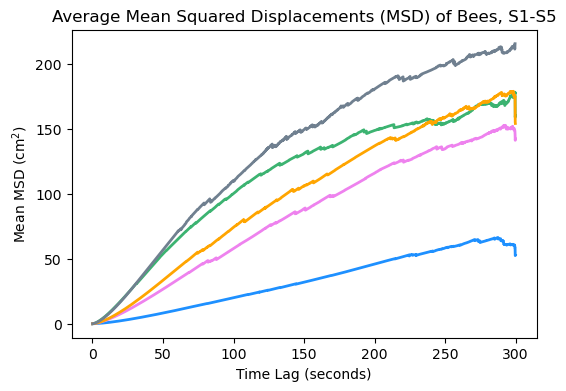

In [ ]:
plt.figure(figsize=(6, 4))
plt.title(f"Average Mean Squared Displacements (MSD) of Bees, S1-S5")
plt.xlabel("Time Lag (seconds)")
plt.ylabel("Mean MSD (cm$^2$)")

colors = ['dodgerblue', 'mediumseagreen', 'violet', 'orange', 'slategrey']  
i = 0

for s, mean_msd_cm in mean_msd_curves_cm.items():
    time_lags_seconds = np.arange(1, len(mean_msd_cm) + 1) / VIDEO_FRAME_RATE

    plt.plot(time_lags_seconds, mean_msd_cm, linewidth=2, color=colors[i], label=f"{s}")
    i += 1

save_path = os.path.join(output_folder_units, f"MSD_avg_cm_all_S(n).png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
#plt.legend()
plt.show()


MSD of all bees individually

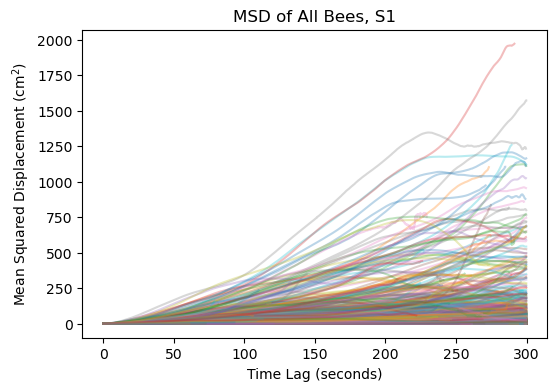

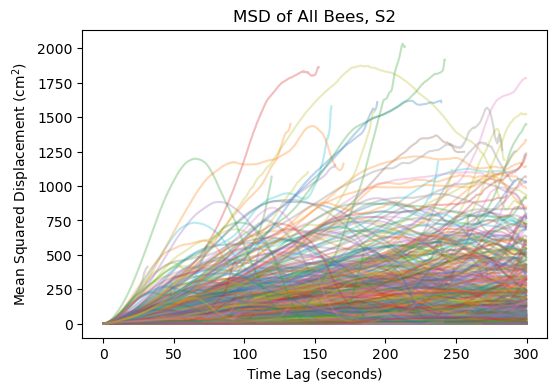

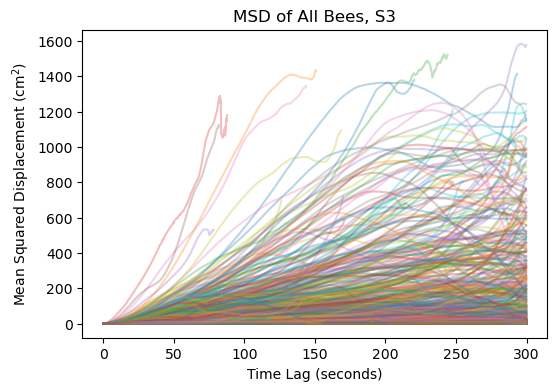

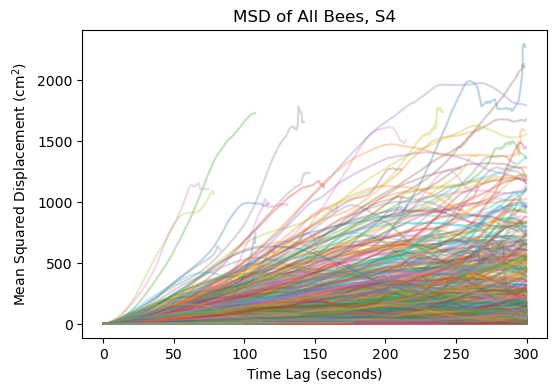

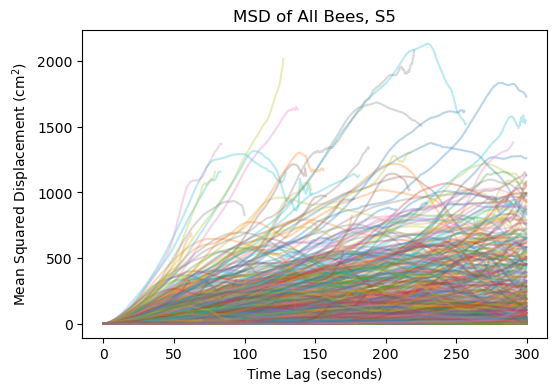

Time taken: 12.2262 seconds


In [ ]:
start_time = time.time()

for s, msd_list_cm in all_msd_curves_cm.items():
    plt.figure(figsize=(6,4))
    plt.title(f"MSD of All Bees, {s}")
    plt.xlabel("Time Lag (seconds)")
    plt.ylabel("Mean Squared Displacement (cm$^2$)")

    for i, msd_curve_cm in enumerate(msd_list_cm): 
        plt.plot(time_lags_seconds, msd_curve_cm, alpha=0.3, label=f"Bee {i+1}") 


    save_path = os.path.join(output_folder_units, f"MSD_all_cm_{s}.png") 
    plt.savefig(save_path, dpi = 300, bbox_inches="tight")

    plt.show()

end_time = time.time()
print(f"Time taken: {end_time - start_time:.4f} seconds")

Plotting AVG MSD in LogLog, with a line of best fit split into two time ranges, with centimeters, with a split point

Slope (Range 1) for S1: 1.48
Slope (Range 2) for S1: 1.20


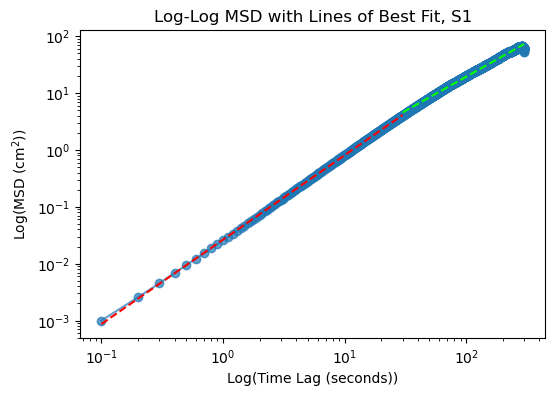

Slope (Range 1) for S2: 1.48
Slope (Range 2) for S2: 0.67


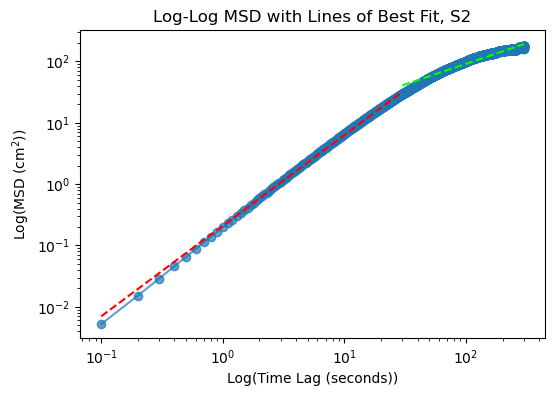

Slope (Range 1) for S3: 1.48
Slope (Range 2) for S3: 1.01


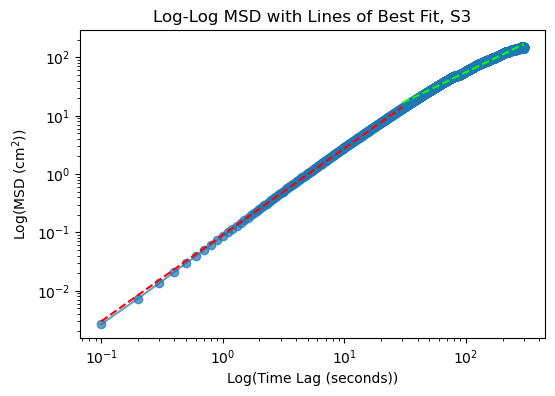

Slope (Range 1) for S4: 1.52
Slope (Range 2) for S4: 0.96


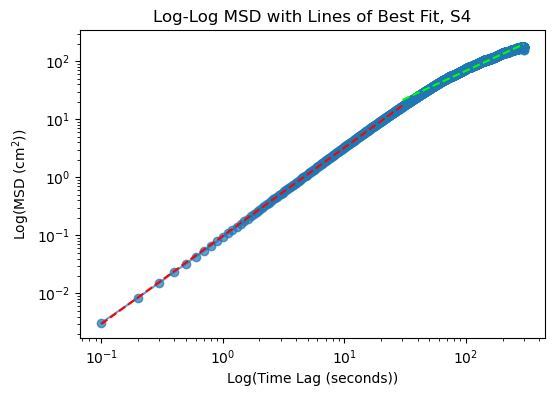

Slope (Range 1) for S5: 1.52
Slope (Range 2) for S5: 0.77


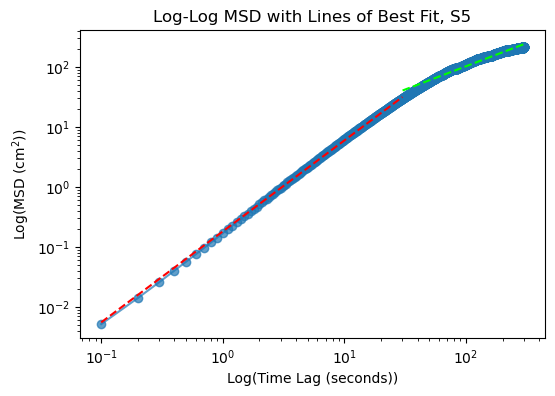

In [12]:
for s, mean_msd_cm in mean_msd_curves_cm.items():
    n_time_points = len(mean_msd_cm)

    time_lags_seconds = np.arange(1, n_time_points + 1) / VIDEO_FRAME_RATE # Convert to NumPy array


    # It is useful to learn more about the best fit lines when they're split up

    # Define the split point
    split_time_seconds = 30 # Arbitrarily chosen time

    # time_lags_seconds[n_time_points // 2] # to split the time lags in half
    

    # Range 1: Up to the split point 
    indices_range1 = time_lags_seconds <= split_time_seconds
    time_lags_range1 = time_lags_seconds[indices_range1]
    msd_range1 = mean_msd_cm[indices_range1]

    # Filter out non-positive values for the logarithm in range 1
    valid_indices_range1 = (msd_range1 > 0) & (time_lags_range1 > 0)
    log_time_lags_range1 = np.log(time_lags_range1[valid_indices_range1])
    log_msd_range1 = np.log(msd_range1[valid_indices_range1])

    slope1, intercept1, r_value1, p_value1, std_err1 = linregress(log_time_lags_range1, log_msd_range1)
    line_fit_range1 = intercept1 + slope1 * log_time_lags_range1

    print(f"Slope (Range 1) for {s}: {slope1:.2f}")

    
    # Range 2: After the split point 
    indices_range2 = time_lags_seconds > split_time_seconds
    time_lags_range2 = time_lags_seconds[indices_range2]
    msd_range2 = mean_msd_cm[indices_range2]

    # Filter out non-positive values for the logarithm in range 2
    valid_indices_range2 = (msd_range2 > 0) & (time_lags_range2 > 0)
    log_time_lags_range2 = np.log(time_lags_range2[valid_indices_range2])
    log_msd_range2 = np.log(msd_range2[valid_indices_range2])

    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(log_time_lags_range2, log_msd_range2)
    line_fit_range2 = intercept2 + slope2 * log_time_lags_range2

    print(f"Slope (Range 2) for {s}: {slope2:.2f}")
    

    # Plotting 
    plt.figure(figsize=(6, 4))
    plt.title(f"Log-Log MSD with Lines of Best Fit, {s}")
    plt.xlabel("Log(Time Lag (seconds))")
    plt.ylabel("Log(MSD (cm$^2$))")
    plt.ticklabel_format(style='plain')

    # Log plot
    plt.loglog(time_lags_seconds, mean_msd_cm, marker='o', alpha=0.7, linestyle='-', label="Log-Log MSD (cm$^2$)")

    # Best fit line for the first range
    plt.plot(np.exp(log_time_lags_range1), np.exp(line_fit_range1), color='red', linestyle='--', label=f"Time Range 1 (Slope = {slope1:.2f})")

    # Best fit line for the second range
    plt.plot(np.exp(log_time_lags_range2), np.exp(line_fit_range2), color='lime', linestyle='--', label=f"Time Range 2 (Slope = {slope2:.2f})")
    

    save_path = os.path.join(output_folder_units, f"MSD_loglog_fit_cm_{s}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

Subplots with all 5 loglog + best fit line graphs. For presentation purposes

Slope (Range 1) for S1: 1.48
Slope (Range 2) for S1: 1.20

Slope (Range 1) for S2: 1.48
Slope (Range 2) for S2: 0.67

Slope (Range 1) for S3: 1.48
Slope (Range 2) for S3: 1.01

Slope (Range 1) for S4: 1.52
Slope (Range 2) for S4: 0.96

Slope (Range 1) for S5: 1.52
Slope (Range 2) for S5: 0.77



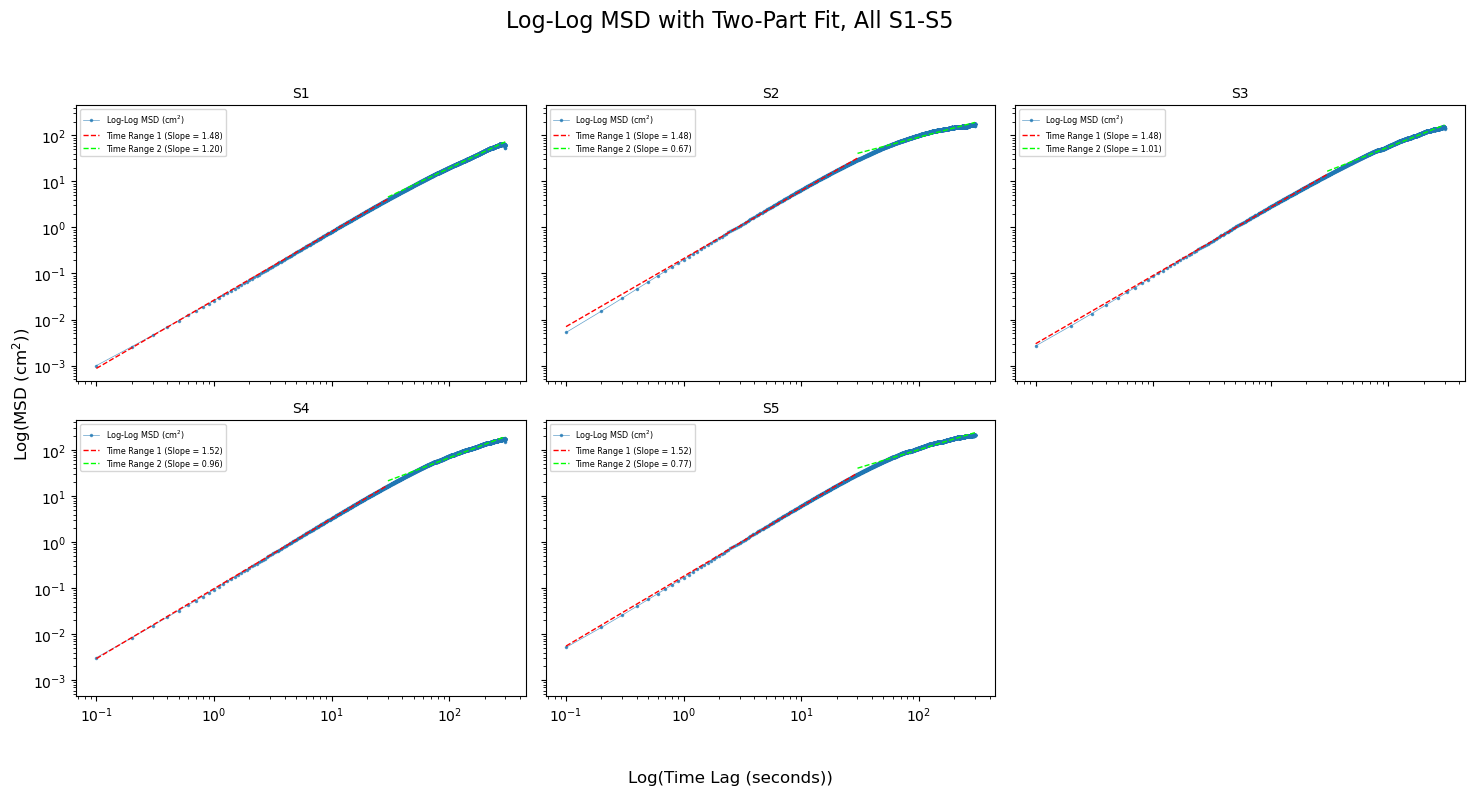

In [ ]:
subjects = sorted(mean_msd_curves_cm.keys())  # consistent order
n_subplots = len(subjects)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharex=True, sharey=True)
fig.suptitle("Log-Log MSD with Two-Part Fit, All S1-S5", fontsize=16)

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, s in enumerate(subjects):
    ax = axes[i]
    mean_msd_cm = mean_msd_curves_cm[s]
    n_time_points = len(mean_msd_cm)
    time_lags_seconds = np.arange(1, n_time_points + 1) / VIDEO_FRAME_RATE

    split_time_seconds = 30

    ax.loglog(time_lags_seconds, mean_msd_cm, marker='.', alpha=0.7, markersize=3, linestyle='-', linewidth=0.5, label="Log-Log MSD (cm$^2$)")

    # Range 1 
    indices_range1 = time_lags_seconds <= split_time_seconds
    time_lags_range1 = time_lags_seconds[indices_range1]
    msd_range1 = mean_msd_cm[indices_range1]
    valid_indices_range1 = (msd_range1 > 0) & (time_lags_range1 > 0)
    log_time_lags_range1 = np.log(time_lags_range1[valid_indices_range1])
    log_msd_range1 = np.log(msd_range1[valid_indices_range1])

    if len(log_time_lags_range1) > 1:
        slope1, intercept1, _, _, _ = linregress(log_time_lags_range1, log_msd_range1)
        line_fit_range1 = intercept1 + slope1 * log_time_lags_range1
        ax.plot(np.exp(log_time_lags_range1), np.exp(line_fit_range1), color='red', linestyle='--', linewidth=1, label=f"Time Range 1 (Slope = {slope1:.2f})")
        print(f"Slope (Range 1) for {s}: {slope1:.2f}")
    else:
        print(f"Not enough data points in Range 1 for regression in {s}")

    # Range 2 
    indices_range2 = time_lags_seconds > split_time_seconds
    time_lags_range2 = time_lags_seconds[indices_range2]
    msd_range2 = mean_msd_cm[indices_range2]
    valid_indices_range2 = (msd_range2 > 0) & (time_lags_range2 > 0)
    log_time_lags_range2 = np.log(time_lags_range2[valid_indices_range2])
    log_msd_range2 = np.log(msd_range2[valid_indices_range2])

    if len(log_time_lags_range2) > 1:
        slope2, intercept2, _, _, _ = linregress(log_time_lags_range2, log_msd_range2)
        line_fit_range2 = intercept2 + slope2 * log_time_lags_range2
        ax.plot(np.exp(log_time_lags_range2), np.exp(line_fit_range2), color='lime', linestyle='--', linewidth=1, label=f"Time Range 2 (Slope = {slope2:.2f})")
        print(f"Slope (Range 2) for {s}: {slope2:.2f}")
        print()
    else:
        print(f"Not enough data points in Range 2 for regression in {s}")

    # Plot details
    
    ax.set_title(s, fontsize=10)
    ax.legend(fontsize='xx-small')

# Remove any unused subplots if the number of subjects is less than 6
if n_subplots < 6:
    for j in range(n_subplots, 6):
        fig.delaxes(axes[j])

# Set common labels
fig.supxlabel("Log(Time Lag (seconds))", fontsize=12)
fig.supylabel("Log(MSD (cm$^2$))", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
save_path = os.path.join(output_folder_units, f"all_MSD_loglog_fit_cm_subplots.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

Plotting all 5 AVG MSD lines in LogLog, with a line of best fit, on one plot (same as above, just on one plot)

Slope (Time Range 1) for S1: 1.48
Slope (Time Range 2) for S1: 1.20

Slope (Time Range 1) for S2: 1.48
Slope (Time Range 2) for S2: 0.67

Slope (Time Range 1) for S3: 1.48
Slope (Time Range 2) for S3: 1.01

Slope (Time Range 1) for S4: 1.52
Slope (Time Range 2) for S4: 0.96

Slope (Time Range 1) for S5: 1.52
Slope (Time Range 2) for S5: 0.77



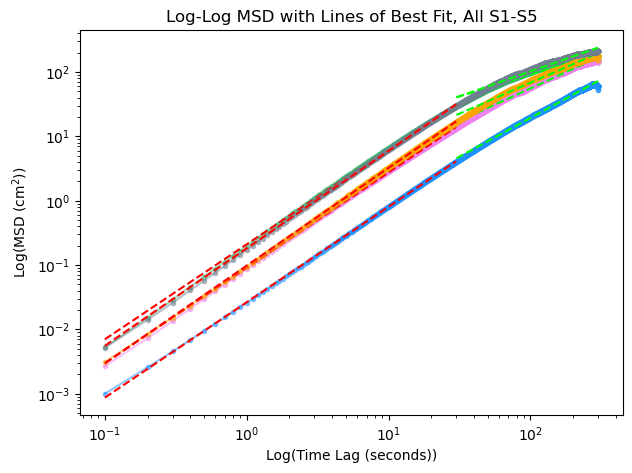

In [11]:
plt.figure(figsize=(7, 5))
plt.title(f"Log-Log MSD with Lines of Best Fit, All S1-S5")
plt.xlabel("Log(Time Lag (seconds))")
plt.ylabel("Log(MSD (cm$^2$))")
plt.ticklabel_format(style='plain')

colors = ['dodgerblue', 'mediumseagreen', 'violet', 'orange', 'slategrey'] 
i = 0

for s, mean_msd_cm in mean_msd_curves_cm.items():
    n_time_points = len(mean_msd_cm)

    time_lags_seconds = np.arange(1, len(mean_msd_cm) + 1) / VIDEO_FRAME_RATE # Convert to NumPy array

    # this line creates the log plot 
    plt.loglog(time_lags_seconds, mean_msd_cm, marker='.', alpha=.5, linestyle='-', color=colors[i], label="Log-Log MSD (cm$^2$)")
    i = i + 1

    # Define the split point
    split_time_seconds = 30

    # Range 1: Up to the split point
    indices_range1 = time_lags_seconds <= split_time_seconds
    time_lags_range1 = time_lags_seconds[indices_range1]
    msd_range1 = mean_msd_cm[indices_range1]

    # Filter out non-positive values for the logarithm in range 1
    valid_indices_range1 = (msd_range1 > 0) & (time_lags_range1 > 0)
    log_time_lags_range1 = np.log(time_lags_range1[valid_indices_range1])
    log_msd_range1 = np.log(msd_range1[valid_indices_range1])

    if len(log_time_lags_range1) > 1:
        slope1, intercept1, _, _, _ = linregress(log_time_lags_range1, log_msd_range1)
        line_fit_range1 = intercept1 + slope1 * log_time_lags_range1
        plt.plot(np.exp(log_time_lags_range1), np.exp(line_fit_range1), color='red', linestyle='--', alpha=1,
                    label=f"Fit 1 ({s}, Slope={slope1:.2f})")
        print(f"Slope (Time Range 1) for {s}: {slope1:.2f}")
    else:
        print(f"Not enough data points in Range 1 for regression in {s}")

    # Range 2: After the split point 
    indices_range2 = time_lags_seconds > split_time_seconds
    time_lags_range2 = time_lags_seconds[indices_range2]
    msd_range2 = mean_msd_cm[indices_range2]

    # Filter out non-positive values for the logarithm in range 2
    valid_indices_range2 = (msd_range2 > 0) & (time_lags_range2 > 0)
    log_time_lags_range2 = np.log(time_lags_range2[valid_indices_range2])
    log_msd_range2 = np.log(msd_range2[valid_indices_range2])

    # Plot details
    if len(log_time_lags_range2) > 1:
        slope2, intercept2, _, _, _ = linregress(log_time_lags_range2, log_msd_range2)
        line_fit_range2 = intercept2 + slope2 * log_time_lags_range2
        plt.plot(np.exp(log_time_lags_range2), np.exp(line_fit_range2), color='lime', linestyle='--', alpha=1,
                    label=f"Fit 2 ({s}, Slope={slope2:.2f})")
        print(f"Slope (Time Range 2) for {s}: {slope2:.2f}")
        print()
    else:
        print(f"Not enough data points in Range 2 for regression in {s}")
    

save_path = os.path.join(output_folder_units, f"all_MSD_loglog_fit_cm_{s}.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

Plotting all 5 LogLog and best fit lines, with an overall average line on top

Average Slope (Range 1): 1.50
Average Slope (Range 2): 0.85


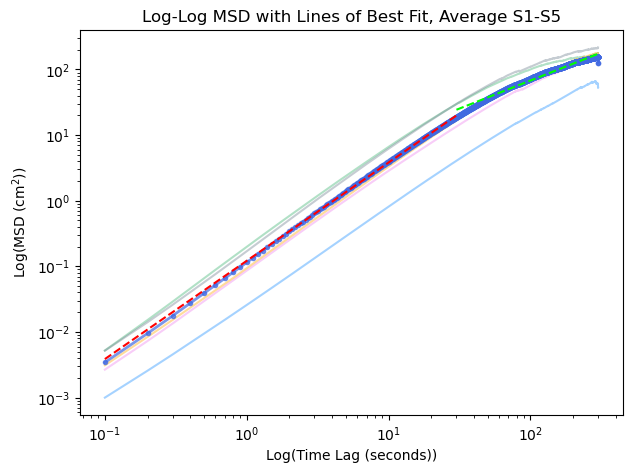

In [ ]:
subjects = ['S1', 'S2', 'S3', 'S4', 'S5']

# Collect the mean MSD curves for all subjects into a single array
all_mean_msd = np.array([mean_msd_curves_cm[s] for s in subjects])

# Calculate the average MSD across all subjects at each time lag
average_msd_across_subjects = np.nanmean(all_mean_msd, axis=0)

# Calculate the standard deviation of the MSD across all subjects at each time lag
std_dev_msd_across_subjects = np.nanstd(all_mean_msd, axis=0)

# Generate the time lag array
n_time_points = len(average_msd_across_subjects)
time_lags_seconds = np.arange(1, n_time_points + 1) / VIDEO_FRAME_RATE

# Define the split point
split_time_seconds = 30

# Range 1: Up to the split point for the average MSD 
indices_range1_avg = time_lags_seconds <= split_time_seconds
time_lags_range1_avg = time_lags_seconds[indices_range1_avg]
msd_range1_avg = average_msd_across_subjects[indices_range1_avg]

# Filter out non-positive values for the logarithm in range 1
valid_indices_range1_avg = (msd_range1_avg > 0) & (time_lags_range1_avg > 0)
log_time_lags_range1_avg = np.log(time_lags_range1_avg[valid_indices_range1_avg])
log_msd_range1_avg = np.log(msd_range1_avg[valid_indices_range1_avg])

slope1_avg, intercept1_avg, _, _, _ = linregress(log_time_lags_range1_avg, log_msd_range1_avg)
line_fit_range1_avg = intercept1_avg + slope1_avg * log_time_lags_range1_avg
print(f"Average Slope (Range 1): {slope1_avg:.2f}")

# Range 2: After the split point for the average MSD 
indices_range2_avg = time_lags_seconds > split_time_seconds
time_lags_range2_avg = time_lags_seconds[indices_range2_avg]
msd_range2_avg = average_msd_across_subjects[indices_range2_avg]

# Filter out non-positive values for the logarithm in range 2
valid_indices_range2_avg = (msd_range2_avg > 0) & (time_lags_range2_avg > 0)
log_time_lags_range2_avg = np.log(time_lags_range2_avg[valid_indices_range2_avg])
log_msd_range2_avg = np.log(msd_range2_avg[valid_indices_range2_avg])

slope2_avg, intercept2_avg, _, _, _ = linregress(log_time_lags_range2_avg, log_msd_range2_avg)
line_fit_range2_avg = intercept2_avg + slope2_avg * log_time_lags_range2_avg
print(f"Average Slope (Range 2): {slope2_avg:.2f}")

# Plotting 
plt.figure(figsize=(7, 5))
plt.title("Log-Log MSD with Lines of Best Fit, Average S1-S5")
plt.xlabel("Log(Time Lag (seconds))")
plt.ylabel("Log(MSD (cm$^2$))")
plt.ticklabel_format(style='plain')

colors = ['dodgerblue', 'mediumseagreen', 'violet', 'orange', 'slategrey']  
i = 0

# Plot the individual log-log MSD curves with transparency
for s, mean_msd_cm in mean_msd_curves_cm.items():
    n_time_points_individual = len(mean_msd_cm)
    if n_time_points_individual > 0:
        time_lags_seconds_individual = np.arange(1, n_time_points_individual + 1) / VIDEO_FRAME_RATE
        valid_indices_individual = (mean_msd_cm > 0) & (time_lags_seconds_individual > 0)
        plt.loglog(time_lags_seconds_individual[valid_indices_individual], mean_msd_cm[valid_indices_individual], alpha=0.4, color=colors[i], linestyle='-', label=f"MSD ({s})")
        i += 1


# Log-Log plot of the average MSD
plt.loglog(time_lags_seconds, average_msd_across_subjects, marker='.', alpha=.7, linewidth=2, color='royalblue', label="Average Log-Log MSD (cm$^2$)")

# Calculate log of standard deviation (handle potential non-positive values)
std_dev_log_msd = np.log(std_dev_msd_across_subjects, where=std_dev_msd_across_subjects > 0, out=np.full_like(std_dev_msd_across_subjects, np.nan))
log_avg_msd = np.log(average_msd_across_subjects, where=average_msd_across_subjects > 0, out=np.full_like(average_msd_across_subjects, np.nan))

# Fill between for standard deviation (in log space)
# plt.fill_between(time_lags_seconds, np.exp(log_avg_msd - std_dev_log_msd), np.exp(log_avg_msd + std_dev_log_msd), color='gray', alpha=0.3, label="Standard Deviation")
# omit stdev for presentation

# Best fit line for the first range of the average MSD
plt.plot(np.exp(log_time_lags_range1_avg), np.exp(line_fit_range1_avg), color='red', linestyle='--', label=f"Fit 1 (Slope = {slope1_avg:.2f})")

# Best fit line for the second range of the average MSD
plt.plot(np.exp(log_time_lags_range2_avg), np.exp(line_fit_range2_avg), color='lime', linestyle='--', label=f"Fit 2 (Slope = {slope2_avg:.2f})")

save_path = os.path.join(output_folder_units, f"all_avg_MSD_loglog_fit_cm_{s}.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

### Plots (NO UNITS. OLD CODE FROM PRIOR TESTING)

In [ ]:
# Plotting AVG MSD. This is for the image saving with the curve by itself, but the figure is closed after being saved. 
for s, mean_msd in mean_msd_curves.items():
    plt.figure(figsize=(6,4))  # Create a new figure for all mean MSD curves
    plt.title(f"Average Mean Squared Displacement (MSD) of Bees, {s}")
    plt.xlabel("Time Lag (frames)")
    plt.ylabel("Mean MSD")

    plt.plot(range(1, len(mean_msd)+1), mean_msd, linewidth=2, label="Average MSD")

    save_path = os.path.join(output_folder, f"MSD_avg_{s}.png") 
    plt.savefig(save_path, dpi = 300, bbox_inches="tight")

    plt.close()
    #plt.show()

# Plotting AVG MSD with STD
for s, mean_msd in mean_msd_curves.items():
    std_dev_msd = std_dev_msd_curves_timelag[s]
    time_lags = range(1, len(mean_msd) + 1)
    
    plt.figure(figsize=(6,4))  # Create a new figure for all mean MSD curves
    plt.title(f"Average MSD of Bees with Standard Deviation, {s}")
    plt.xlabel("Time Lag (frames)")
    plt.ylabel("Mean MSD")

    plt.plot(time_lags, mean_msd, linewidth=2, label="Average MSD", color='blue')
    plt.fill_between(time_lags, mean_msd - std_dev_msd, mean_msd + std_dev_msd, color='blue', alpha=0.2, label="Standard Deviation")

    save_path = os.path.join(output_folder, f"MSD_avg_std_{s}.png") 
    plt.savefig(save_path, dpi = 300, bbox_inches="tight")
    
    #plt.close()
    plt.show()

    
    

In [ ]:
# Plotting AVG MSD in LogLog, with a line of best fit

for s, mean_msd in mean_msd_curves.items():
    time_lags = np.arange(1, len(mean_msd) + 1)  # Convert to NumPy array

    # Filter out any NaN values before taking the logarithm
    valid_indices = ~np.isnan(mean_msd)
    log_time_lags = np.log(time_lags[valid_indices])
    log_msd = np.log(mean_msd[valid_indices])

    # Perform linear regression to get the line of best fit
    slope, intercept, r_value, p_value, std_err = linregress(log_time_lags, log_msd)
    line_fit = intercept + slope * log_time_lags # y = mx + b form

    plt.figure(figsize=(6, 4))
    plt.title(f"Log-Log MSD with Line of Best Fit, {s}")
    plt.xlabel("Log(Time Lag (frames))")
    plt.ylabel("Log(MSD)")

    # this line creates the log plot 
    plt.loglog(time_lags, mean_msd, marker='o', linestyle='-', label="Log-Log MSD")

    # this line creates the best fit line 
    plt.plot(np.exp(log_time_lags), np.exp(line_fit), color='red', linestyle='--', label=f"Fit (Slope = {slope:.2f})")

    save_path = os.path.join(output_folder, f"MSD_loglog_fit_{s}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
# Plotting ALL MSD Lines
start_time = time.time()

for s, msd_list in all_msd_curves.items():
    plt.figure(figsize=(6,4))
    plt.title(f"MSD of Bees, {s}")
    plt.xlabel("Time Lag (frames)")
    plt.ylabel("Mean Squared Displacement (MSD)")
    plt.ticklabel_format(style='plain')

    for i, msd_curve in enumerate(msd_list): 
        plt.plot(range(1, len(msd_curve) + 1), msd_curve, alpha=0.3, label=f"Bee {i+1}") 


    save_path = os.path.join(output_folder, f"MSD_all_{s}.png") 
    plt.savefig(save_path, dpi = 300, bbox_inches="tight")

    plt.show()

end_time = time.time()
print(f"Time taken: {end_time - start_time:.4f} seconds")

### Plotting Histograms of all_msd_curves
Extra information- originally wanted to use this in order to determine where the dividing point of the two best fit lines of the logarithm graph would go. 

In [ ]:
# assumes all_msd_curves has been loaded

output_folder_histograms = "../supplementary_plots"
os.makedirs(output_folder_histograms, exist_ok=True)

In [ ]:
# Collect all MSD values from all bees across all subjects
all_msd_values_hists = []
for s, msd_list in all_msd_curves.items():
    for msd_curve in msd_list:
        all_msd_values_hists.extend(msd_curve)

all_msd_values_hists = np.array(all_msd_values_hists)

# Remove NaN values if any, since they shouldn't get tossed into buckets
all_msd_values_hists = all_msd_values_hists[~np.isnan(all_msd_values_hists)]

print("amount of data points:", len(all_msd_values_hists)) # verification

# TESTING DIFFERENT TECHNIQUES FOR BIN SIZES #
n_data_points = len(all_msd_values_hists)

# SQRT RULE
n_bins_sqrt = int(np.sqrt(n_data_points))

# STURGES RULE
n_bins_sturges = int(np.log2(n_data_points)) + 1

plt.figure(figsize=(10, 6))

# providing an integer for bins= makes that the bin amount. you could also add defined edges
plt.hist(all_msd_values_hists, bins=n_bins_sturges, edgecolor='black', alpha=0.7)

plt.title("Histogram of All Individual Bee MSD Values")
plt.xlabel("MSD (pixels$^2$)")
plt.ylabel("Frequency")

plt.yscale('log') # Using a log scale for the y-axis can be helpful for skewed distributions
plt.grid(True, which="both", ls="-", alpha=0.5)

save_path = os.path.join(output_folder_histograms, "all_bee_msd_histogram.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()